# Naive Bayes - Trained on the Sentiment 140 data set
In this section we'll attempt to build a custom Naive Bayes model for text classification. Naive Bayes classifiers use conditional probabilities based on pre-tagged data, so we will use pre-tagged data containing about 1.6 million tweets tagged for negative (0) and positive (4) sentiment. Try training and running a multinomial Naive Bayes model from sklearn. To "vectorize" the text, we must first apply a TFIDF (term-frequency/inverse document frequency) transformation to model the text values as numeric values.

https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

In [48]:
import os
import pandas as pd
from comment_scraper import get_sql_table # local module
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
from tabulate import tabulate
from datetime import datetime

plt.style.use('seaborn-notebook')

# supress warnings from sklearn
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# slklearn imports
from sklearn.feature_extraction.text import HashingVectorizer # alternative to tf-idf vectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords


In [3]:
DATA_DIR = 'C:\\Users\\keatu\\Regis_archive\\practicum2_data\\'
dbname = os.path.join(DATA_DIR, "Youtube_Data_msnbc.db")

In [4]:
s140df = pd.read_csv(os.path.join(DATA_DIR,"resources","s140_preproc.csv"), encoding='latin-1')

In [5]:
# forgot to concat the strings together when I created the csv
s140df['preproc_text_concat'] = s140df['preproc_text'].apply(lambda x: " ".join(eval(x)))

In [6]:
text=s140df['text']
target=s140df['target']
train_text, test_text, train_label, test_label=train_test_split(text, target, random_state=50)
print(train_label.value_counts())

4    600017
0    599983
Name: target, dtype: int64


### Fit and train initial model

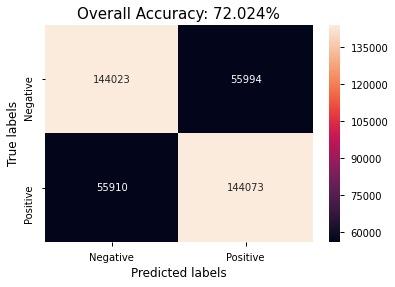

In [7]:
# Put hashing vectorizer into a preprocessing pipeline
estimators=[('vectorizer', HashingVectorizer(ngram_range=(1,1)))] # keep bag of words to 1 for now
pipeline = Pipeline(estimators)

# transform/vectorize the input training text
train_text_proc = pipeline.fit_transform(train_text)

# create the initial model
nb_model = BernoulliNB()
nb_model.fit(train_text_proc, train_label)

# score the model performance on the test data
test_text_proc = pipeline.fit_transform(test_text)
test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)

# Show overall accuracy and plot the confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', size=12)
ax.set_ylabel('True labels', size=12)
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15)
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive'])

### Try using pre-processed text
Primarily just lemmatizing the words based on part of speach (see pre_proc.py). 

In [11]:
s140df[['text','preproc_text_concat']].head()

,text,preproc_text_concat
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - awww , ..."
1,is upset that he can't update his Facebook by ...,be upset that he can't update his facebook by ...
2,@Kenichan I dived many times for the ball. Man...,@kenichan i dive many time for the ball . mana...
3,my whole body feels itchy and like its on fire,my whole body feel itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....","@nationwideclass no , it's not behave at all ...."


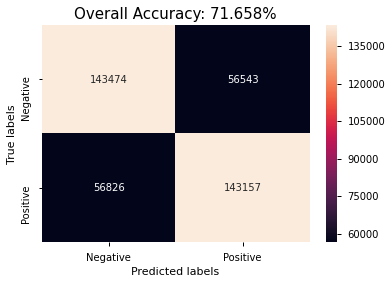

In [12]:
# run same training/prediction/visualization steps as first model
preproc_text=s140df['preproc_text_concat']
target=s140df['target']
train_text, test_text, train_label, test_label=train_test_split(preproc_text, target, random_state=50)
estimators=[('vectorizer', HashingVectorizer(ngram_range=(1,1)))]
pipeline = Pipeline(estimators)
train_text_proc = pipeline.fit_transform(train_text)
nb_model = BernoulliNB()
nb_model.fit(train_text_proc, train_label)
test_text_proc = pipeline.fit_transform(test_text)
test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)
# Show overall accuracy and confusion matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15); 
ax.xaxis.set_ticklabels(['Negative', 'Positive']); ax.yaxis.set_ticklabels(['Negative', 'Positive']);

Adding preprocessing steps does not appear to add any value. The hashing vectorizer function by default does some pre-processing on the text before vectorizing, but it does not lemmatize. Perhaps the lemmatization bins different words together that actually hurt the model's performance. I tried a few different methods for pre-processing the text, but none of them improved accuracy. So let's move forward with the default model--no preprocessing.

### Parameter optimization

In [14]:
# reset out training/test data
text=s140df['text']
target=s140df['target']
train_text, test_text, train_label, test_label=train_test_split(text, target, random_state=50)
print(train_label.value_counts())

4    600017
0    599983
Name: target, dtype: int64


#### Increase Laplace Smoothing Parameter (alpha)

2022-08-13 21:07:50.580546 - transforming train text
2022-08-13 21:08:03.491170 - fit the model
2022-08-13 21:08:04.115795 - score the model


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

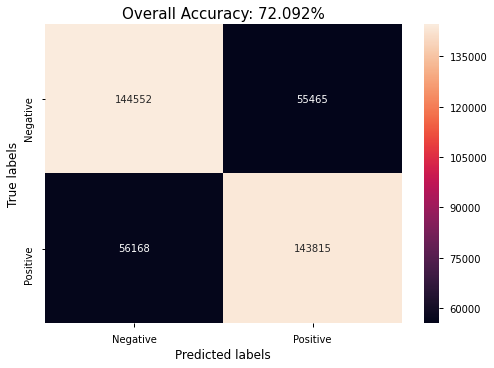

In [32]:
estimators=[('vectorizer', HashingVectorizer(ngram_range=(1,1)))]
pipeline = Pipeline(estimators)
print("{} - transforming train text".format(datetime.now()))
train_text_proc = pipeline.fit_transform(train_text)
print("{} - fit the model".format(datetime.now())
# increased smoothing
nb_model = BernoulliNB(alpha = 5)
nb_model.fit(train_text_proc, train_label)
print("{} - score the model".format(datetime.now()))
test_text_proc = pipeline.fit_transform(test_text)
test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', size=12)
ax.set_ylabel('True labels', size=12)
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

#### Increase ngram_range

2022-08-13 21:08:21.750737 - transforming train text
2022-08-13 21:08:44.866516 - fit the model
2022-08-13 21:08:45.986873 - score the model


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

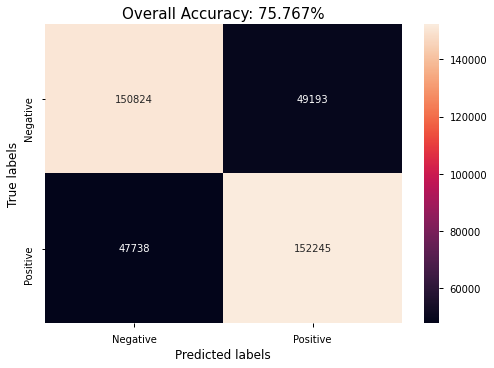

In [33]:
# increase ngram range
estimators=[('vectorizer', HashingVectorizer(ngram_range=(1,2)))]
pipeline = Pipeline(estimators)
print("{} - transforming train text".format(datetime.now()))
train_text_proc = pipeline.fit_transform(train_text)
print("{} - fit the model".format(datetime.now()))
nb_model = BernoulliNB(alpha = 5)
nb_model.fit(train_text_proc, train_label)
print("{} - score the model".format(datetime.now()))
test_text_proc = pipeline.fit_transform(test_text)
test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', size=12)
ax.set_ylabel('True labels', size=12)
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

#### Increase # of features
The n_features parameter of the vectorizer defines the # of columns to use in the output matrices.

2022-08-13 21:10:20.126472 - transforming train text
2022-08-13 21:10:44.049790 - fit the model
2022-08-13 21:10:45.877762 - score the model


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

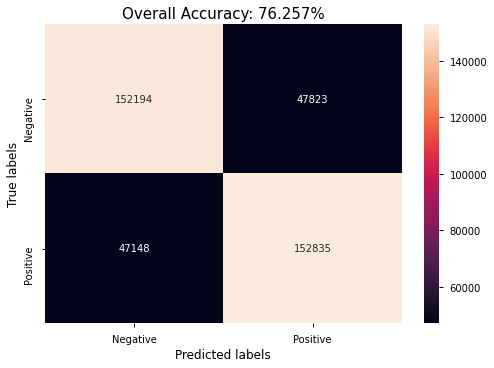

In [35]:
# increase n_features (default is 2 ** 20)
estimators=[('vectorizer', HashingVectorizer(ngram_range=(1,2), n_features=2**24))]
pipeline = Pipeline(estimators)
print("{} - transforming train text".format(datetime.now()))
train_text_proc = pipeline.fit_transform(train_text)
print("{} - fit the model".format(datetime.now()))
nb_model = BernoulliNB(alpha = 5)
nb_model.fit(train_text_proc, train_label)
print("{} - score the model".format(datetime.now()))
test_text_proc = pipeline.fit_transform(test_text)
test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', size=12)
ax.set_ylabel('True labels', size=12)
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

#### Set binary to True
Sets all non-zero counts to 1--useful for binary classification models

2022-08-14 07:11:42.867671 - transforming train text
2022-08-14 07:12:05.952466 - fit the model
2022-08-14 07:12:08.208175 - score the model


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

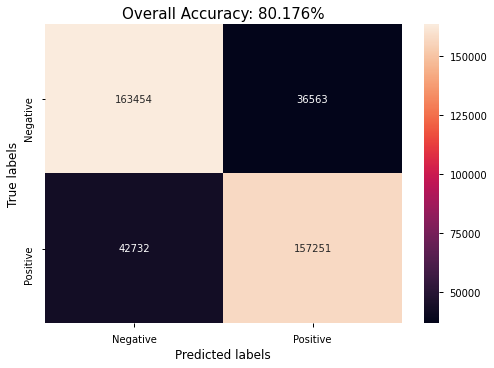

In [63]:
# set binary to True
estimators=[('vectorizer',
    HashingVectorizer(
        ngram_range=(1,2),
        n_features=2**25,
        binary = True))]
pipeline = Pipeline(estimators)
print("{} - transforming train text".format(datetime.now()))
train_text_proc = pipeline.fit_transform(train_text)
print("{} - fit the model".format(datetime.now()))
nb_model = BernoulliNB(alpha = 2)
nb_model.fit(train_text_proc, train_label)
print("{} - score the model".format(datetime.now()))
test_text_proc = pipeline.fit_transform(test_text)
test_score = nb_model.score(test_text_proc,test_label)
predicted_vals = nb_model.predict(test_text_proc)
ax= plt.subplot()
sns.heatmap(confusion_matrix(test_label,predicted_vals), annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels', size=12)
ax.set_ylabel('True labels', size=12)
ax.set_title('Overall Accuracy: {:.3f}%'.format(test_score*100.0), size=15)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])

In [65]:
nb_model.classes_

array([0, 4], dtype=int64)

#### Other preprocessing

In [66]:
filename = 'bernoullinb_model.sav'
with open(filename,'wb') as f:
    pickle.dump(nb_model, f)

# load it later
# with open(filename, 'rb') as f:
#    model = pickle.load(f)